# Coral Bleaching
## Predicting the Likelihood and Severity of Coral Reef Bleaching Events Based on Various Environmental Factors

Authors: Jaimie Chin & Maro Aboelwafa  
Course: DS.UA.301 - Advanced Topics in Data Science: Machine Learning for Climate Change  
Date: 22 March 2023  

## Background
The climate issue we are tackling is predicting the likelihood and severity of coral reef bleaching events based on various environmental factors. Coral reefs are sensitive to environmental changes such as temperature, salinity, nutrient levels and water acidity. When these factors reach certain thresholds, they  trigger coral bleaching, a process in which the coral expels the symbiotic algae that live on it, causing the coral to turn white and possibly die.

To address this, we aim to use machine learning to analyze datasets of environmental data, such as water temperature to develop algorithms that can predict the likelihood and severity of coral bleaching events.

### Data 
We will be using the Bleaching and environmental data for global coral reef sites (1980-2020) from the Biological & Chemical Oceanography Data Management Office. The data includes information on the presence and absence of coral bleaching, allowing comparative analyses and the determination of geographical bleaching thresholds, together with site exposure, distance to land, mean turbidity, cyclone frequency, and a suite of sea-surface temperature metrics at the times of survey. 

Data Server: [Bleaching and Environmental Data](http://dmoserv3.whoi.edu/jg/info/BCO-DMO/Coral_Reef_Brightspots/bleaching_and_env_data%7Bdir=dmoserv3.whoi.edu/jg/dir/BCO-DMO/Coral_Reef_Brightspots/,data=dmoserv3.bco-dmo.org:80/jg/serv/BCO-DMO/Coral_Reef_Brightspots/global_bleaching_environmental.brev0%7D?)


## Import Packages

In [1]:
# Import packages & libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## Load Dataset 

In [2]:
# Import Global Bleaching & Environmental Data 
data_path = "data/global_bleaching_environmental.csv"
types = {'Distance_to_Shore': float, 'Turbidity': float, 'Percent_Bleaching': float}
bleach_df = pd.read_csv(data_path, sep='\s*[,]\s*', engine='python', na_values=['nd'], dtype=types)

In [3]:
# View sample of the data 
bleach_df.sample(5)

,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Reef_ID,Realm_Name,Ecoregion_Name,Country_Name,...,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Date,Site_Comments,Sample_Comments,Bleaching_Comments
7553,1514,10320926,Reef_Check,17.3440,-88.0292,Atlantic,88.01.45.2W.17.20.38.5N,Tropical Atlantic,Belize and west Caribbean,Belize,...,6.0,1.0,0.0,1.28,11.67,0.47,2004-08-05,NaN,NaN,NaN
40154,8700,10318970,Reef_Check,18.3500,-64.8648,Atlantic,64.51.885W.18.21.001N,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,5.0,0.0,0.0,0.71,6.21,0.20,2002-05-14,NaN,NaN,NaN
35225,141,10313594,Reef_Check,-14.9156,145.6908,Pacific,145.41.456E.14.54.935S,Central Indo-Pacific,Central and northern Great Barrier Reef,Australia,...,5.0,1.0,0.0,1.21,7.71,0.48,1998-08-05,NaN,NaN,NaN
19117,7682,10318994,Reef_Check,18.0882,-65.4619,Atlantic,65.27.42.84W.18.5.17.67N,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,6.6,0.2,0.0,0.94,8.52,0.25,2015-06-24,NaN,NaN,NaN
9066,2977,10317297,Reef_Check,25.1576,34.8553,Red Sea,34.51.19.2E.25.9.27.5N,Western Indo-Pacific,North and central Red Sea,Egypt,...,10.0,1.0,0.0,1.96,16.30,0.63,2010-02-13,NaN,NaN,NaN


## Data Cleaning & Exploration

In [4]:
# Let's first see how large our dataset is for evaluation 
bleach_df.shape

(41361, 62)

### Feature Information & Null Values 
Let's observe our features to determine what could be used in our model analysis

In [5]:
# Let's see out features and datatypes 
bleach_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                28821 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41358 non-null  object 
 9   Country_Name                           41360 non-null  object 
 10  State_Island_Province_Name             41262 non-null  object 
 11  Ci

In [6]:
# Let's see our null values for each feature 
# Number of missing data within each attribute
null_df = pd.DataFrame(bleach_df.isna().sum(), columns=['Null_Count'])
null_df[null_df['Null_Count'] != 0]

,Null_Count
Reef_ID,12540
Ecoregion_Name,3
Country_Name,1
State_Island_Province_Name,99
City_Town_Name,1133
Site_Name,34429
Distance_to_Shore,2
Turbidity,6
Depth_m,1799
Substrate_Name,12668


Looking at the number of null values for each feature, our target feature **Percent_Bleaching** have a higher number of null values than we would like. For better accuracy and generalizability, we may decide to drop all samples that do not have our target feature.

Otherwise, looking at the other null values, it seems that there are some features that can be dropped due to its irrelevancy within Coral Bleaching literature, and some features that can use imputed score. How we will impute these scores will be determined. 

### Dropping Irrelevant/Redundant Features 
Based on prior literature, we can drop some irrelevant and redundant features:
1. Site_ID - Irrelevant to predicting bleaching events due to coral environment
2. Sample_ID - Irrelevant to predicting bleaching events due to coral environment
3. Data_Source (Source of data set) - Irrelevant to predicting bleaching events due to coral environment 
4. Date_Day - Month and Year are more generalizable for this data 
5. Date - Month and Year are more generalizable for this data
6. Reef_ID (Unique identifier from Reef Check data) - Irrelevant to predicting bleaching events due to coral environment 
7. State_Island_Province_Name (The state, territory (e.g., Guam) or island group (e.g., Hawaiian Islands) where sampling took place) - Already using latitude and longitude
8. City_Town_Name (The region, city, or nearest town, where sampling took place) - Already using latitude and longitude
9. Site_Name (The accepted name of the site or the name given by the team that sampled the reef) - Irrelevant to predicting bleaching events due to coral environment 
10. Bleaching_Level (Reef Check data, coral population or coral colony) - Less detailed than target feature 'Percent_Bleaching'
11. Site_Comments - Too variant and many nulls
12. Sample_Comments - Too variant and many nulls
13. Bleaching_Comments - Too variant and many nulls

In [7]:
# Drop irrelevant/redundant features
bleach_CL_df = bleach_df.drop(['Site_ID', 'Sample_ID', 'Data_Source', 'Date_Day', 'Date', 'Reef_ID', 'State_Island_Province_Name', 'City_Town_Name',
                                    'Site_Name', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments'], axis=1)

# Drop any rows where the target feature is null and some missing qualitative rows

bleach_CL_df = bleach_CL_df[bleach_CL_df['Percent_Bleaching'].notna()]
bleach_CL_df = bleach_CL_df[bleach_CL_df['Ecoregion_Name'].notna()]
bleach_CL_df = bleach_CL_df[bleach_CL_df['Country_Name'].notna()]

In [8]:
# Let's see the shape of our data again 
bleach_CL_df.shape

(34512, 49)

### Distributions & Visualizations
We need to see some distributions of the features that need to be imputed 

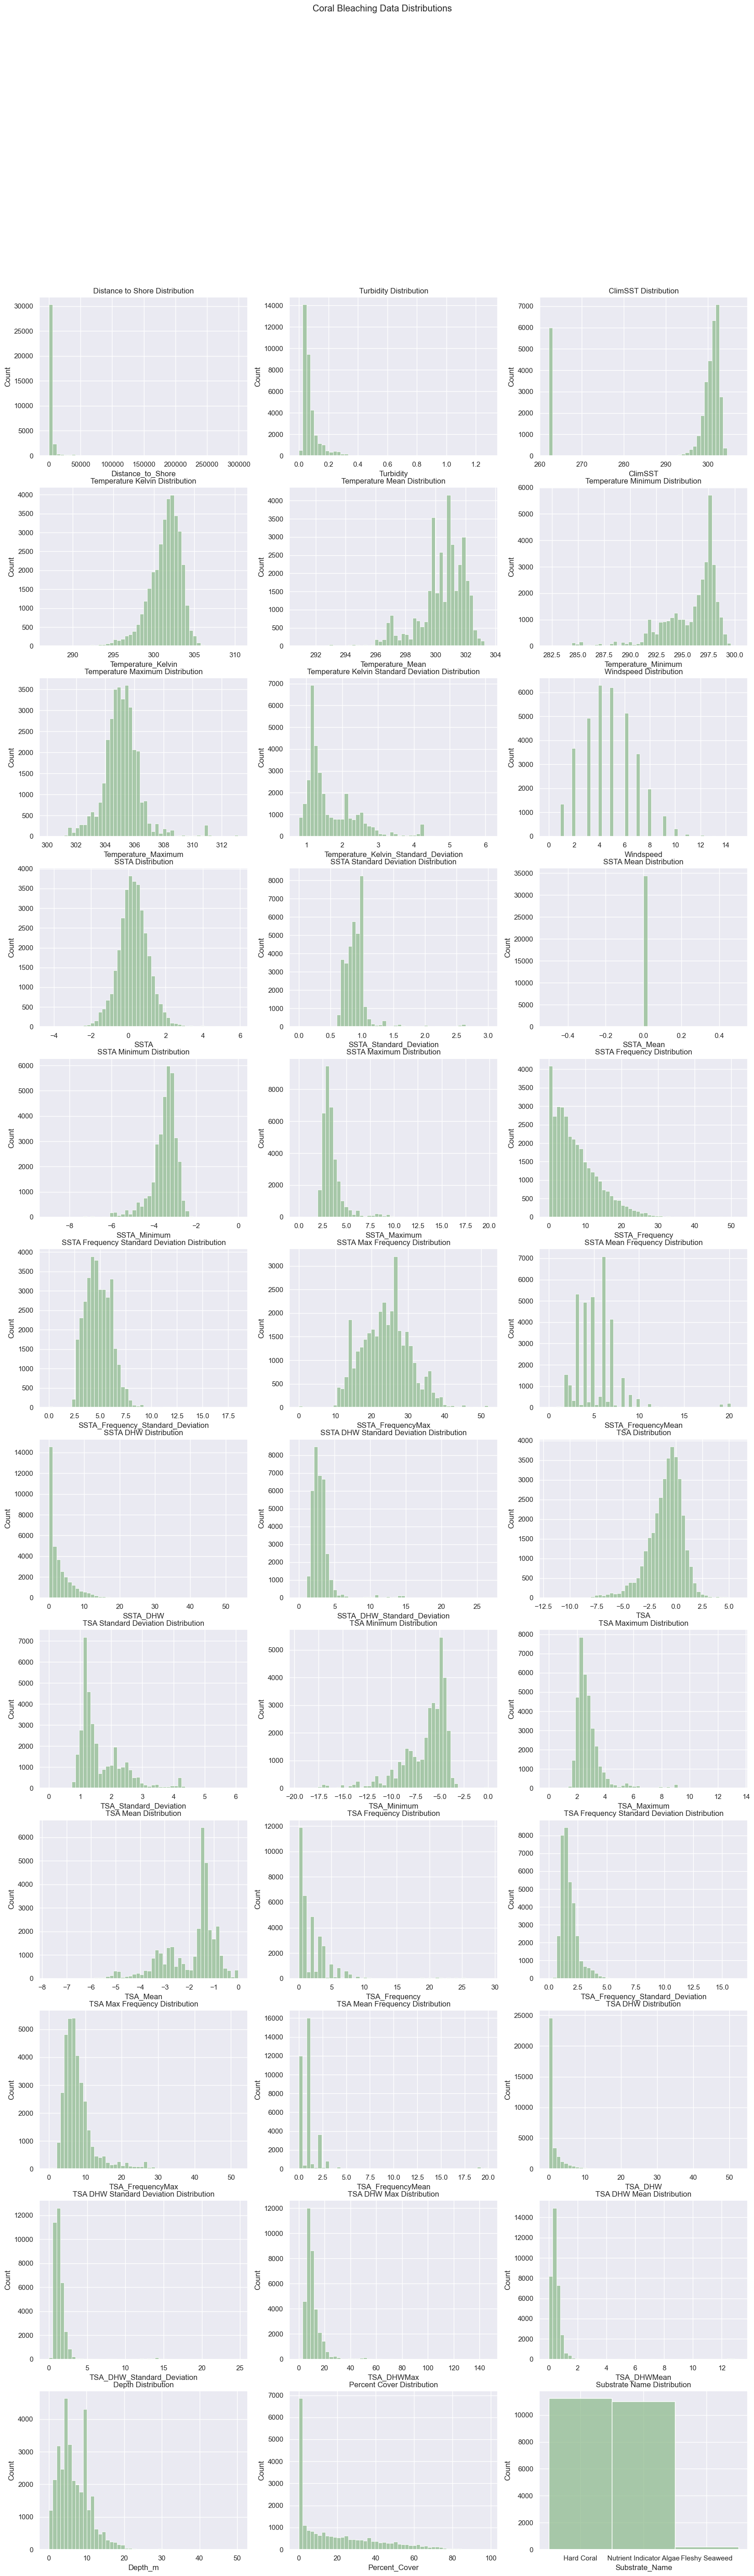

In [9]:
# Set seaborn figure
sns.set(style="darkgrid")
fig, axs = plt.subplots(12, 3, figsize=(20, 64))

# Plotting some relevant features 
fig.suptitle('Coral Bleaching Data Distributions')

sns.histplot(data=bleach_CL_df, x="Distance_to_Shore",
             color="darkseagreen", bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Distance to Shore Distribution')

sns.histplot(data=bleach_CL_df, x="Turbidity",
             color="darkseagreen", bins=50, ax=axs[0, 1])
axs[0, 1].set_title('Turbidity Distribution')

sns.histplot(data=bleach_CL_df, x="ClimSST", color="darkseagreen", bins=50, ax=axs[0, 2])
axs[0, 2].set_title('ClimSST Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin",
             color="darkseagreen", bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Temperature Kelvin Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Mean",
             color="darkseagreen", bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Temperature Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Minimum",
             color="darkseagreen", bins=50, ax=axs[1, 2])
axs[1, 2].set_title('Temperature Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Maximum",
             color="darkseagreen", bins=50, ax=axs[2, 0])
axs[2, 0].set_title('Temperature Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[2, 1])
axs[2, 1].set_title('Temperature Kelvin Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="Windspeed",
             color="darkseagreen", bins=50, ax=axs[2, 2])
axs[2, 2].set_title('Windspeed Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA",
             color="darkseagreen", bins=50, ax=axs[3, 0])
axs[3, 0].set_title('SSTA Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[3, 1])
axs[3, 1].set_title('SSTA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Mean",
             color="darkseagreen", bins=50, ax=axs[3, 2])
axs[3, 2].set_title('SSTA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Minimum",
             color="darkseagreen", bins=50, ax=axs[4, 0])
axs[4, 0].set_title('SSTA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Maximum",
             color="darkseagreen", bins=50, ax=axs[4, 1])
axs[4, 1].set_title('SSTA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency",
             color="darkseagreen", bins=50, ax=axs[4, 2])
axs[4, 2].set_title('SSTA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[5, 0])
axs[5, 0].set_title('SSTA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[5, 1])
axs[5, 1].set_title('SSTA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[5, 2])
axs[5, 2].set_title('SSTA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW",
             color="darkseagreen", bins=50, ax=axs[6, 0])
axs[6, 0].set_title('SSTA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[6, 1])
axs[6, 1].set_title('SSTA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA",
             color="darkseagreen", bins=50, ax=axs[6, 2])
axs[6, 2].set_title('TSA Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[7, 0])
axs[7, 0].set_title('TSA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Minimum",
             color="darkseagreen", bins=50, ax=axs[7, 1])
axs[7, 1].set_title('TSA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Maximum",
             color="darkseagreen", bins=50, ax=axs[7, 2])
axs[7, 2].set_title('TSA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Mean",
             color="darkseagreen", bins=50, ax=axs[8, 0])
axs[8, 0].set_title('TSA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency",
             color="darkseagreen", bins=50, ax=axs[8, 1])
axs[8, 1].set_title('TSA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[8, 2])
axs[8, 2].set_title('TSA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[9, 0])
axs[9, 0].set_title('TSA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[9, 1])
axs[9, 1].set_title('TSA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW",
             color="darkseagreen", bins=50, ax=axs[9, 2])
axs[9, 2].set_title('TSA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[10, 0])
axs[10, 0].set_title('TSA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMax",
             color="darkseagreen", bins=50, ax=axs[10, 1])
axs[10, 1].set_title('TSA DHW Max Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMean",
             color="darkseagreen", bins=50, ax=axs[10, 2])
axs[10, 2].set_title('TSA DHW Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Depth_m",
             color="darkseagreen", bins=50, ax=axs[11, 0])
axs[11, 0].set_title('Depth Distribution')

sns.histplot(data=bleach_CL_df, x="Percent_Cover",
             color="darkseagreen", bins=50, ax=axs[11, 1])
axs[11, 1].set_title('Percent Cover Distribution')

sns.histplot(data=bleach_CL_df, x="Substrate_Name",
             color="darkseagreen", ax=axs[11, 2])
axs[11, 2].set_title('Substrate Name Distribution')

plt.show()

Looking at the distributions for features that are missing data, each feature has a generally skewed distribution.

We decided to use the Multiple Imputation Method to impute our data given that our goal is to impute values that are unbiased (and are therefore generalizable) and recovers the population variance, which is critical to statistical inference for our prediction models. 

### Data Imputation 

In [10]:
# Create a copy of our data 
bleach_na_df = bleach_CL_df.copy()[['Distance_to_Shore', 'Turbidity', 'Depth_m', 'Percent_Cover', 
                                    'ClimSST', 'Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum', 
                                    'Temperature_Maximum', 'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 
                                    'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Mean',  'SSTA_Minimum', 
                                    'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation', 
                                    'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW', 
                                    'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA', 
                                    'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean', 
                                    'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax', 
                                    'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation', 'TSA_DHWMax', 
                                    'TSA_DHWMean']]                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Instantiate Imputer
imputer = IterativeImputer(random_state=0, max_iter=10)

# Fit on the dataset 
imputer.fit(bleach_na_df)
bleach_imputed_df = imputer.transform(bleach_na_df)

# Replace clean dataframe with imputed values
bleach_CL_df.loc[:, ['Distance_to_Shore', 'Turbidity', 'Depth_m', 'Percent_Cover',
                     'ClimSST', 'Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum',
                     'Temperature_Maximum', 'Temperature_Kelvin_Standard_Deviation', 'Windspeed',
                     'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Mean',  'SSTA_Minimum',
                     'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
                     'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
                     'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
                     'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
                     'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
                     'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation', 'TSA_DHWMax',
                     'TSA_DHWMean']] = bleach_imputed_df

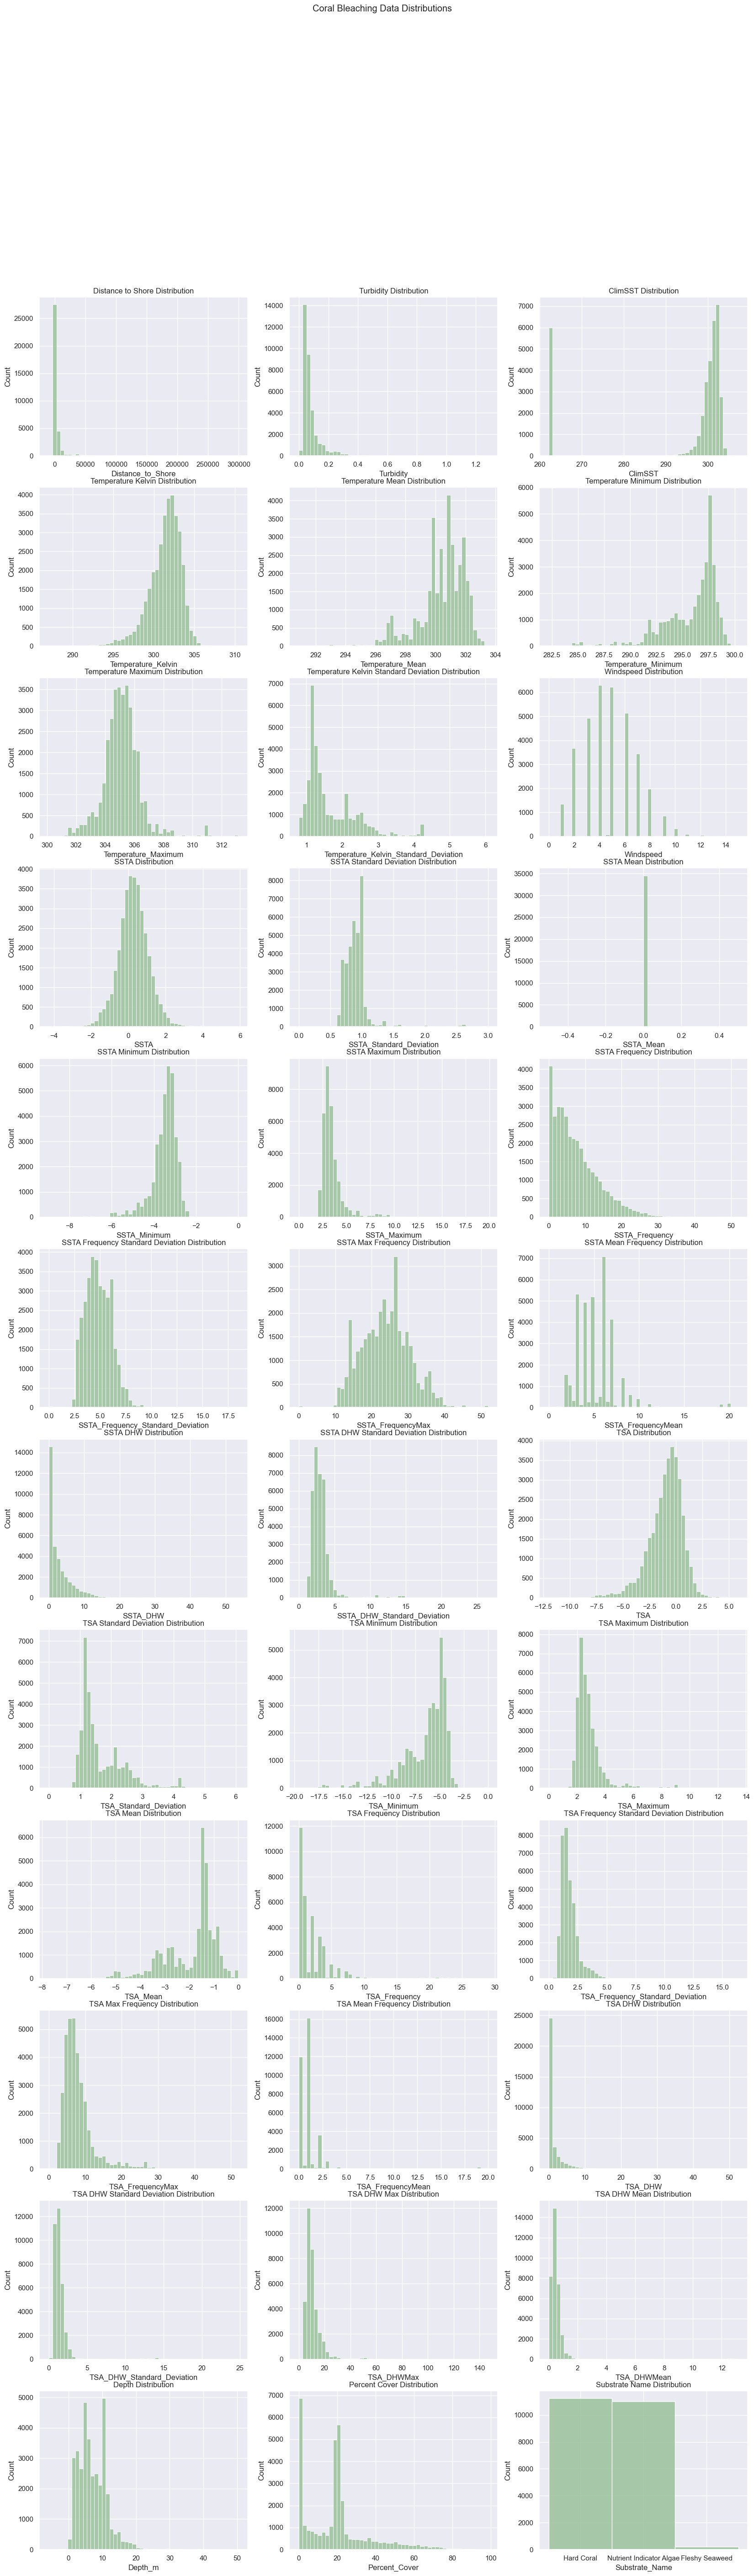

In [11]:
# Let's check our distributions one more time to see how our imputed data looks
# Set seaborn figure
sns.set(style="darkgrid")
fig, axs = plt.subplots(12, 3, figsize=(20, 64))

# Plotting some relevant features
fig.suptitle('Coral Bleaching Data Distributions')

sns.histplot(data=bleach_CL_df, x="Distance_to_Shore",
             color="darkseagreen", bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Distance to Shore Distribution')

sns.histplot(data=bleach_CL_df, x="Turbidity",
             color="darkseagreen", bins=50, ax=axs[0, 1])
axs[0, 1].set_title('Turbidity Distribution')

sns.histplot(data=bleach_CL_df, x="ClimSST",
             color="darkseagreen", bins=50, ax=axs[0, 2])
axs[0, 2].set_title('ClimSST Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin",
             color="darkseagreen", bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Temperature Kelvin Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Mean",
             color="darkseagreen", bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Temperature Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Minimum",
             color="darkseagreen", bins=50, ax=axs[1, 2])
axs[1, 2].set_title('Temperature Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Maximum",
             color="darkseagreen", bins=50, ax=axs[2, 0])
axs[2, 0].set_title('Temperature Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[2, 1])
axs[2, 1].set_title('Temperature Kelvin Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="Windspeed",
             color="darkseagreen", bins=50, ax=axs[2, 2])
axs[2, 2].set_title('Windspeed Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA",
             color="darkseagreen", bins=50, ax=axs[3, 0])
axs[3, 0].set_title('SSTA Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[3, 1])
axs[3, 1].set_title('SSTA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Mean",
             color="darkseagreen", bins=50, ax=axs[3, 2])
axs[3, 2].set_title('SSTA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Minimum",
             color="darkseagreen", bins=50, ax=axs[4, 0])
axs[4, 0].set_title('SSTA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Maximum",
             color="darkseagreen", bins=50, ax=axs[4, 1])
axs[4, 1].set_title('SSTA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency",
             color="darkseagreen", bins=50, ax=axs[4, 2])
axs[4, 2].set_title('SSTA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[5, 0])
axs[5, 0].set_title('SSTA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[5, 1])
axs[5, 1].set_title('SSTA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[5, 2])
axs[5, 2].set_title('SSTA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW",
             color="darkseagreen", bins=50, ax=axs[6, 0])
axs[6, 0].set_title('SSTA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[6, 1])
axs[6, 1].set_title('SSTA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA",
             color="darkseagreen", bins=50, ax=axs[6, 2])
axs[6, 2].set_title('TSA Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[7, 0])
axs[7, 0].set_title('TSA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Minimum",
             color="darkseagreen", bins=50, ax=axs[7, 1])
axs[7, 1].set_title('TSA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Maximum",
             color="darkseagreen", bins=50, ax=axs[7, 2])
axs[7, 2].set_title('TSA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Mean",
             color="darkseagreen", bins=50, ax=axs[8, 0])
axs[8, 0].set_title('TSA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency",
             color="darkseagreen", bins=50, ax=axs[8, 1])
axs[8, 1].set_title('TSA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[8, 2])
axs[8, 2].set_title('TSA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[9, 0])
axs[9, 0].set_title('TSA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[9, 1])
axs[9, 1].set_title('TSA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW",
             color="darkseagreen", bins=50, ax=axs[9, 2])
axs[9, 2].set_title('TSA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[10, 0])
axs[10, 0].set_title('TSA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMax",
             color="darkseagreen", bins=50, ax=axs[10, 1])
axs[10, 1].set_title('TSA DHW Max Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMean",
             color="darkseagreen", bins=50, ax=axs[10, 2])
axs[10, 2].set_title('TSA DHW Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Depth_m",
             color="darkseagreen", bins=50, ax=axs[11, 0])
axs[11, 0].set_title('Depth Distribution')

sns.histplot(data=bleach_CL_df, x="Percent_Cover",
             color="darkseagreen", bins=50, ax=axs[11, 1])
axs[11, 1].set_title('Percent Cover Distribution')

sns.histplot(data=bleach_CL_df, x="Substrate_Name",
             color="darkseagreen", ax=axs[11, 2])
axs[11, 2].set_title('Substrate Name Distribution')

plt.show()

In [12]:
# Let's check for any missing values again 
# Number of missing data within each feature
null_df = pd.DataFrame(bleach_CL_df.isna().sum(), columns=['Null_Count'])
null_df[null_df['Null_Count'] != 0]

,Null_Count
Substrate_Name,12044


It seems that the only feature left is a qualitative feature with 12,044 missing values. We could impute this with the most frequent value, but this method does not consider dependencies among feature values. We think it is better to drop this feature all together to preserve sample size. 

In [13]:
# Let's drop the 'substrate_name' feature from our dataset 
bleach_CL_df = bleach_CL_df.drop(['Substrate_Name'], axis=1)

In [14]:
# Final shape of the dataset
bleach_CL_df.shape

(34512, 48)

## Splitting the Data for Model Building and Analysis 

Now that we have cleaned the dataset, we want to split our data into 3 datasets, a training set (to train our model), a test set (to test our final model after adjusting parameters), and a validation set to validate our model's hyperparameters.

In [15]:
# Split entire dataset into a train and test set 
train_df, test_df = train_test_split(bleach_CL_df, test_size=0.2, random_state=0)

# Separate target feature from the train and test sets 
y_test = test_df['Percent_Bleaching'].copy()
X_test = test_df.drop(['Percent_Bleaching'], axis=1)

per_bleach_df = train_df['Percent_Bleaching'].copy()
train_df = train_df.drop(['Percent_Bleaching'], axis=1)

# Split the train dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_df, per_bleach_df, test_size=0.2, random_state=0)


In [16]:
# Let's check the sizes of our data sets 
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of validating examples: {X_val.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 22087
No. of validating examples: 5522
No. of testing examples: 6903


## Encoding Categorical Features 

In [17]:
# Save feature names
features = X_train.columns

# label encode any categorical features
le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = le.fit_transform(X_train[column].values.reshape(-1, 1))
        X_val[column] = le.transform(X_val[column].values.reshape(-1, 1))
        X_test[column] = le.transform(X_test[column].values.reshape(-1, 1))

## Feature Selection (Mutual Information-Based Feature Selection) -- TO CHANGE LATER

Now that we have our dataset to build the model, we want to do some preprocessing to reduce the amount of features used in building our model. Our current dataset has 48 features. 

We decided to use the Mutual Information-Based Feature Selection Method because for a dataset with 48 features that has a mix of both numerical and categorical data, we want to evaluate the mutual information between the target variable and each feature in the dataset. The mutual information between two variables measures the amount of information that one variable provides about the other. In other words, it measures how much knowledge of one variable reduces the uncertainty of the other variable.

Mutual information-based feature selection is a suitable method for datasets with a mix of numerical and categorical features because it is a non-parametric method that can handle different types of variables. It works by calculating the mutual information between the target variable and each feature, regardless of their data type. This method can identify relevant features that might be missed by other feature selection methods that rely on correlation measures, which only capture linear relationships between numerical variables.

Furthermore, mutual information-based feature selection can capture non-linear relationships between variables, which is important in many real-world problems. It can also handle redundant features, meaning that it can identify features that might be highly correlated with each other but do not provide any additional information about the target variable.

In [18]:
# Let's standardize our data before feature selection 
# Data Preprocessing
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_val = sc_x.transform(X_val)
X_test = sc_x.transform(X_test)


In [19]:
# select the k best features based on mutual information
selector = SelectKBest(f_regression, k=15)

# Instantiate selected data sets with selected features only
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# get the index of the selected features
selected_features_idx = selector.get_support()
selected_features = [x for x, b in zip(features, selected_features_idx) if b]

# Let's see which features we selected
print(selected_features)

['Longitude_Degrees', 'Ocean_Name', 'Realm_Name', 'Ecoregion_Name', 'Date_Year', 'Depth_m', 'Temperature_Kelvin', 'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Frequency', 'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_DHW']


## Model Implementation
We'll be training the following 3 different models and seeing which one works best:

    - Random Forest
    - Gradient Boosting 
    - ANN

## Random Forest Model

In [20]:
# Create a random forest regressor object
rf = RandomForestRegressor()

# Define the hyperparameters to search over in a grid search
param_grid_rf = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search object to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_val_selected, y_val)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_rf.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Our first gridsearch returned the best hyperparameters as - 

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

But there are a couple more hyperparameters we could adjust, let's confirm we have the best possible model.


In [21]:
# Define the hyperparameters to search over in a grid search
param_grid_rf = {
    'n_estimators': [1000],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

# Create a grid search object to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_val_selected, y_val)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_rf.best_params_)

Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [22]:
# Train a random forest regressor on the training set with the best hyperparameters
rf = RandomForestRegressor(**grid_search_rf.best_params_)
rf.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print('Test RMSE:', rmse_rf)
print('Test R-squared:', r2_rf)

Test RMSE: 11.106970059417575
Test R-squared: 0.6921287879163973


## Gradient Boosting Model

In [23]:
# Create a gradient boosting regressor object
gbr = GradientBoostingRegressor()

# Define the hyperparameters to search over in a grid search
param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 1]
}

# Create a grid search object to find the best hyperparameters
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_val_selected, y_val)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_gbr.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}


In [24]:
# Train a gradient boosting regressor on the training set with the best hyperparameters
gbr = GradientBoostingRegressor(**grid_search_gbr.best_params_)
gbr.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_gbr = gbr.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
r2_gbr = r2_score(y_test, y_pred_gbr)

print('Test RMSE:', rmse_gbr)
print('Test R-squared:', r2_gbr)

Test RMSE: 11.419217545275917
Test R-squared: 0.6745752554792399


## ANN Model

In [25]:
# Create an MLP regressor object
mlp = MLPRegressor()

# Define the hyperparameters to search over in a grid search
param_grid_mlp = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create a grid search object to find the best hyperparameters
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_val_selected, y_val)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_mlp.best_params_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Our first gridsearch returned the best hyperparameters as - 

{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}

But did we find the best amount of layers for our ANN? Let's confirm.

In [26]:
# Define the hyperparameters to search over in a grid search
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100,50), (45,30,15)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.001],
    'learning_rate': ['adaptive'],
    'max_iter': [5000]
}

# Create a grid search object to find the best hyperparameters
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_val_selected, y_val)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_mlp.best_params_)

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (45, 30, 15), 'learning_rate': 'adaptive', 'max_iter': 5000, 'solver': 'adam'}


Now that we tested the number of layers, the best hyperparameters now are with 3 layers! But is it the most accurate?

In [27]:
# Train an MLP regressor on the training set with the best hyperparameters
mlp = MLPRegressor(**grid_search_mlp.best_params_)
mlp.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_mlp = mlp.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_mlp = mean_squared_error(y_test, y_pred_mlp, squared=False)
r2_mlp = r2_score(y_test, y_pred_mlp)

print('Test RMSE:', rmse_mlp)
print('Test R-squared:', r2_mlp)

Test RMSE: 13.227749891436554
Test R-squared: 0.5633335467715354


# Final Stacked Model

In [51]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


# Define the base models
base_models = [('ann', mlp), ('gb', gbr), ('rf', rf)]

# Define the stacking regressor with a random forest meta-model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Fit the model on training data
stacked_model.fit(X_train_selected, y_train)

# Predict on test data
y_pred = stacked_model.predict(X_test_selected)

# Define lower and upper thresholds
lower_threshold = 0
upper_threshold = 100

# Apply clipping to predicted values
predictions = np.clip(y_pred, lower_threshold, upper_threshold)

# Calculate the mean squared error and R-squared on the test set
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Test RMSE:', rmse)
print('Test R-squared:', r2)

Test RMSE: 11.027411325630375
Test R-squared: 0.6965235273483181


## Final Visualizations 
* Plot coral bleaching severity?

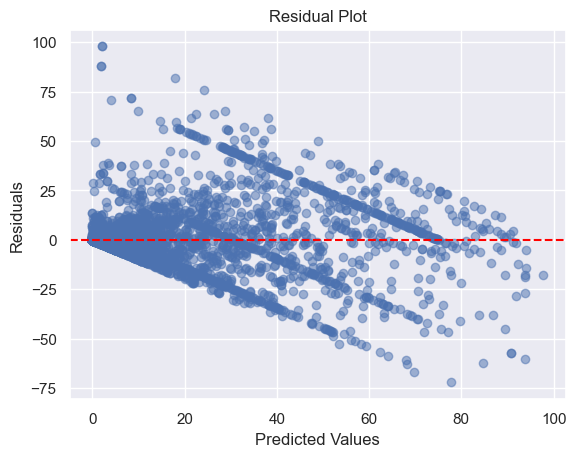

In [56]:
residuals = y_test - predictions

# Create the scatter plot
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [57]:
results = pd.DataFrame({'PREDICTION': predictions, 'ACTUAL': y_test, 'RESIDUALS': np.abs(residuals)})

In [58]:
results['SEVERITY'] = 0
for index, row in results.iterrows():
    if row.loc['PREDICTION'] > 30:
        results.loc[index, 'SEVERITY'] = 'SEVERE'
    elif row.loc['PREDICTION'] <= 0:
        results.loc[index, 'SEVERITY'] = 'LOW'
    elif 0 < row.loc['PREDICTION'] <= 10:
        results.loc[index, 'SEVERITY'] = 'MILD'
    elif 10 < row.loc['PREDICTION'] <= 30:
        results.loc[index, 'SEVERITY'] = 'MODERATE'

In [59]:
results.head()

,PREDICTION,ACTUAL,RESIDUALS,SEVERITY
15904,0.000000,0.0,0.000000,LOW
8227,0.114036,0.0,0.114036,MILD
188,61.281516,60.0,1.281516,SEVERE
14762,0.381150,0.0,0.381150,MILD
19847,0.000000,0.0,0.000000,LOW
